# Programación estadística con Python - II
----

## Agenda

1. Nuestro "*pensum*" de Ciencia de Datos con Python  
<br>
2. Recapitulando el ejercicio anterior  
  + 2.1 Análisis exploratorio de datos (EDA) con la base de salarios de la DGII  
  + 2.2 Distribución acumulada y percentiles
  + 2.3 En este contexto, ¿ganan las mujeres igual o más que los hombres?  
<br>
3. Introducción a la inferencia estadística  
  + 3.1 ¿Qué es la inferencia estadística?
  + 3.2 ¿Por qué es necesaria la inferencia estadística, incluso en esta llamada era del "Big Data"?
  + 3.3 Prueba de hipótesis mediante permutación
  + 3.4 Intervalo de confianza mediante bootstrap

## Nuestro *"pensum"* de Ciencia de Datos con Python
[Nuestra Comunidad](https://www.meetup.com/Comunidad-de-Analitica-en-Santo-Domingo-R-Python/)  
<br>
[Votación: Temas de Interés en Ciencia de Datos con Python](https://www.meetup.com/Comunidad-de-Analitica-en-Santo-Domingo-R-Python/polls/1252269/)  
<br>

## Recapitulando el ejercicio anterior

[Notebook en Github](https://nbviewer.jupyter.org/github/pyrdr/charlas/blob/master/intro_eda_python/intro_pypandas.ipynb)

In [1]:
import pandas as pd

df = pd.read_csv('cs_DGII_Nomina_2016.csv', sep=';', encoding = "ISO-8859-1")

df.columns = [x.strip().lower() for x in df.columns.values]

limpiar_salario = lambda x: pd.to_numeric(x.replace(',','').strip(), errors='coerce')
df.salario = df.salario.apply(limpiar_salario)

from unidecode import unidecode
import re

def limpiar_puesto(pstr):
    pstr = unidecode(pstr).strip().lower()
    pstr = re.sub('\(.*?\)','', pstr)
    pstr = pstr.translate({ord('.'): None, ord(','): None})
    return pstr

df['puesto_clean'] = df.puesto.apply(limpiar_puesto)
# df.puesto_clean.describe()

## Introducción a la Inferencia Estadística

## Nómina de la DGII en el 2016

[Introducción al Análisis Exploratorio de Datos (EDA) con Python](https://github.com/pyrdr/charlas/tree/master/intro_eda_python)

### Pregunta: Según la nómina de la DGII en el 2016, ¿en promedio las mujeres ganan igual que los hombres?

In [2]:
ene = df[df.mes == 'ene-16']
feb = df[df.mes == 'feb-16']

feb_sal_m = feb.salario[df.genero == 'M']
feb_sal_f = feb.salario[df.genero == 'F']

print( feb_sal_m.describe(), "\n")
print( feb_sal_f.describe(), "\n")

print( feb_sal_f.mean() - feb_sal_m.mean() )

count      1113.000000
mean      42226.847835
std       35251.273038
min        5722.670000
25%       20410.000000
50%       34774.000000
75%       51556.000000
max      559600.000000
Name: salario, dtype: float64 

count      1600.000000
mean      44827.896875
std       27224.643133
min        5679.000000
25%       28726.000000
50%       42333.000000
75%       53280.000000
max      339730.000000
Name: salario, dtype: float64 

2601.049040318954


<IPython.core.display.Javascript object>


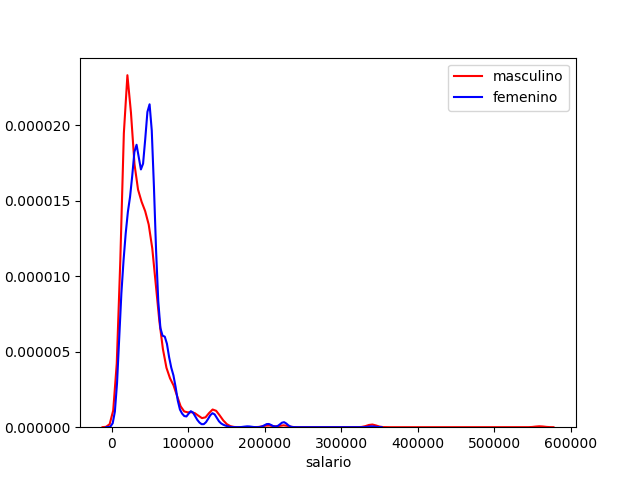

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib notebook

_ = sns.distplot(feb_sal_m, hist=False, color = 'red', label = 'masculino')
_ = sns.distplot(feb_sal_f, hist=False, color = 'blue', label = 'femenino')

plt.show()

<IPython.core.display.Javascript object>


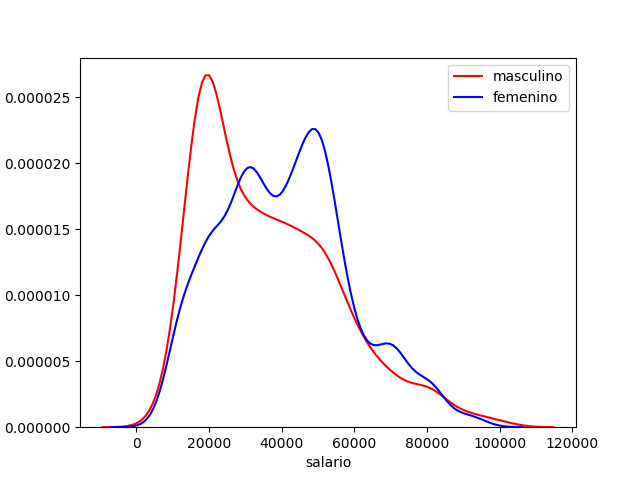

In [20]:
%matplotlib notebook

_ = sns.distplot(feb_sal_m[feb_sal_m < 100000], hist=False, color = 'red', label = 'masculino')
_ = sns.distplot(feb_sal_f[feb_sal_f < 100000], hist=False, color = 'blue', label = 'femenino')

plt.show()

In [19]:
import numpy as np

def ecdf(data):
    """Calcula la función de distribución acumulada empírica 
    para un arreglo de medidas de una sola dimensión."""

    # Cantidad de observaciones: n
    n = len(data)

    # Datos en el eje horizontal: x
    x = np.sort(data)

    # Datos en el eje vertical: y
    y = np.arange(1, len(data)+1) / n

    return x, y

x_m, y_m = ecdf(feb_sal_m)
x_f, y_f = ecdf(feb_sal_f)

<IPython.core.display.Javascript object>


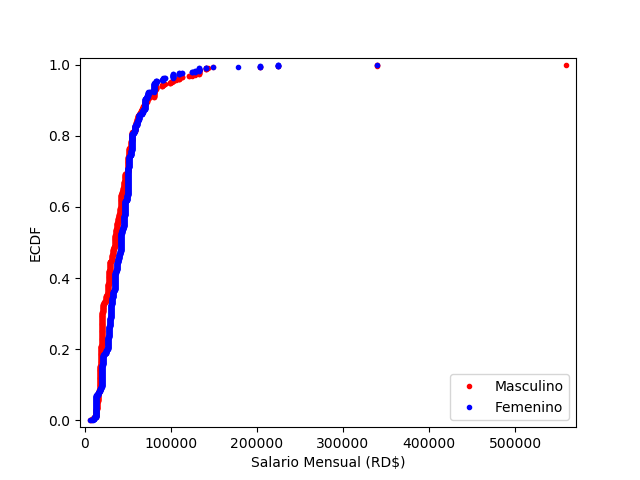

In [17]:
%matplotlib notebook

# Construimos el gráfico
_ = plt.plot(x_m, y_m, marker='.', linestyle='none', color = 'red')
_ = plt.plot(x_f, y_f, marker='.', linestyle='none', color = 'blue')

# Controlamos los márgenes
plt.margins(0.02)

# Creamos anotaciones
plt.legend(('Masculino', 'Femenino'), loc='lower right')
_ = plt.xlabel('Salario Mensual (RD$)')
_ = plt.ylabel('ECDF')

# Desplegamos el gráfico
plt.show()

### Inferencia Estadística ¿Qué es?

![Inferencia Estadística](mod10-big_picture_inference.gif)

### Inferencia Estadística ¿Y esto es necesario en la llamada era del "Big Data"?

![Inferencia Estadística y Big Data - 1](big_data_statistical_inference.jpg)

![Inferencia Estadística y Big Data - 2](big_data_collective_intelligence.png)

![Inferencia Estadística y Big Data - 3](resampling.jpg)

# Prueba de Hipótesis

- En Estadística, una hipótesis es una afirmación sobre un parámetro de la población.  
<br>
- La hipótesis nula es una afirmación que no se rechaza a menos que los datos de la muestra evidencien que es falsa.  
<br>
- Es posible que la diferencia observada entre la media de los hombres y la de las mujeres sea algo aleatorio o un simple error.  
<br>
- Hipótesis nula $H_0: \mu_F = \mu_M$. Es decir, no existe diferencia entre la media salarial de hombres y de mujeres de la DGII.  
<br>
- Y, ¿cómo evaluamos esta hipótesis?  
<br>
- Una prueba de hipótesis estadística, con respecto a alguna característica desconocida de la población de interés, es cualquier regla para decidir si se rechaza la hipótesis nula con base a una muestra aleatoria de la población.  
<br>
- Casi nunca tenemos acceso directo a los datos de la población, de manera que tenemos que recurrir a algo que la represente, al menos en sus parámetros de interés. Para ello recurrimos a lo que se denomina un *estadístico de prueba*.   
<br>
- En principio, para obtener un estadístico de prueba que represente la población, necesitaríamos conocer el proceso de generación de datos en dicha población (Distribución de Probabilidad). Por ahora, a falta de este conocimiento, recurrimos a nuestros métodos de resampling para "simular" las características de dicha población a partir de los datos disponibles.  
<br>
- Por último, necesitamos un criterio que nos ayude a validar nuestra hipótesis a través de dicho estadístico de prueba.  
<br>
- Como queremos evitar equivocarnos, partimos de la probabilidad de rechazar la hipótesis nula condicionada a que la misma sea cierta:  
<br>
$$P(\text{rechazar}\hspace{0.1cm} H_0 \hspace{0.1cm}\mid \hspace{0.1cm} H_0 \hspace{0.1cm}\text{es}\hspace{0.1cm}\text{cierta}) = \alpha$$  
<br>
- Bajo este contexto, el valor $p$ ó $p$-valor se define como la probabilidad de obtener un estadístico de prueba que sea igual o más extremo que lo observado, asumiendo que la hipótesis que se está probando sea cierta. Con este criterio, y el nivel de confianza preestablecido para la prueba, podemos evaluar que tan "pequeña" debe ser dicha probabilidad para poder rechazar la hipótesis nula sin riesgo de equivocarnos.  
<br>
- Resaltamos que el $p$-valor no nos dice *per se* que la hipótesis nula sea verdadera o falsa, sino tan solo que, condicionado a que la misma sea cierta y tomando como base el estadístico de prueba, la probabilidad de obtener datos muestrales que evidencien que nos equivocamos al rechazar dicha hipótesis no supera el porcentaje del $p$-valor.


## Prueba de Hipótesis mediante Permutación

### Pasos:

1- Calculamos la media para cada grupo. Después calculamos la diferencia entre las medias, $D_\text{obs}$.  

<br>
2- Partiendo de la hipótesis que no existen diferencias entre los dos grupos, reasignamos, o lo que es lo mismo, intercambiamos las etiquetas entre las observaciones de ambos grupos, y obtenemos así *todos* los posibles arreglos de reasignación (método *exacto*) o al menos una buena *aproximación* de los mismos.  
 
<br>
3- Para cada arreglo o permutación calculamos a $D$, la diferencia entre las dos medias. Nota: Cada diferencia de medias (o de otro estadístico de prueba que usemos) para cada arreglo muestral se denomina *réplica*.  
  
<br>
4- Encontramos el p-valor.  

$$p-\text{valor}_\text{superior} = \frac{\text{número de}\hspace{0.1cm} \text{D's} >= D_\text{obs}}{m+n \choose n}$$
$$p-\text{valor}_\text{inferior} = \frac{\text{número de}\hspace{0.1cm} \text{D's} <= D_\text{obs}}{m+n \choose n}$$
$$p-\text{valor}_\text{2-colas} = \frac{\text{número de}\hspace{0.1cm} \mid\text{D's}\mid \hspace{0.1cm} >= \hspace{0.1cm}\mid D_\text{obs}\mid}{m+n \choose n}$$
  
<br>
5- Comparamos el $p$-valor con el nivel de significancia preestablecido y llegamos a una conclusión.

In [7]:
# Ejercicio: Si siguiéramos el método exacto, ¿cuántas permutaciones se necesitarían 
# para la prueba de hipótesis de igualdad entre las medias salariales de mujeres y hombres de la DGII?

import math

def nPr(n, r):
    f = math.factorial
    return f(n) // ( f(n - r) )

m_count = feb_sal_m.count()
f_count = feb_sal_f.count()
n = m_count + f_count
r = max(m_count, f_count)


print("hombres:", m_count)
print("mujeres:", f_count) 
print("n:", n)
print("Permutaciones bajo el método exacto:", nPr(n, r))


hombres: 1113
mujeres: 1600
n: 2713
Permutaciones bajo el método exacto: 333011831175559622827054166272053322184093916064837370460440188576403934550733350694759965359266243589920687463088457751779448996844232575653131704674967328883460582825239569847948394034749518215453610057587905375906518110648493985913291477673648974978143272019298770857205882802057132152063870023026583049796590992252596225905180901208933878128451482512112448877048670637783191596071639470520755404340513926641479324922830665033749231209523977619374963544536406392384411442074717957878620799541993014341055294154556501891633639152344777177571479530708875029557908715914376923607016091320678087154377025078369399528492264727974551677909220298442054810882388264444100329201644173072024428978275516633193050503993374059715075057763070724771733399759088899237530864598541236352025608186072647801982968519321973913271366503799331821055954957989817246584322615752267261589840946322231563943460765470836544271264434829120222375379497

In [8]:
def permutation_sample(data1, data2):
    """Genera una muestra de permutación a partir de dos conjuntos de datos."""

    # Concatenamos los datos
    data = np.concatenate((data1, data2))

    # Permutamos los arreglos de datos concatenados
    permuted_data = np.random.permutation(data)

    # Separamos los arreglos permutados en dos
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

<IPython.core.display.Javascript object>


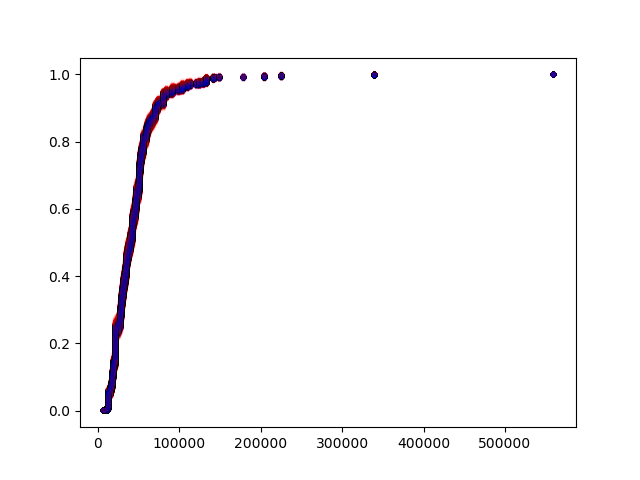

In [16]:
%matplotlib notebook

for i in range(500):
    # Generamos muestras de permutación
    perm_sample_1, perm_sample_2 = permutation_sample(feb_sal_m, feb_sal_f)

    # Calculamos las funciones de distribución acumulada empíricas
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Graficamos las funciones de distribución acumulada empíricas
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue', alpha=0.02)

In [10]:
# Una réplica de permutación consiste en el valor de un estadístico calculado a partir de una muestra de permutación

def draw_perm_reps(data_1, data_2, func, size=1):
    """Genera múltiples réplicas de permutación."""

    # Inicializa un arreglo de réplicas
    perm_replicates = np.empty(size)

    for i in range(size):
        # Genera una muestra de permutación
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Calcula el estadístico de prueba
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

<IPython.core.display.Javascript object>


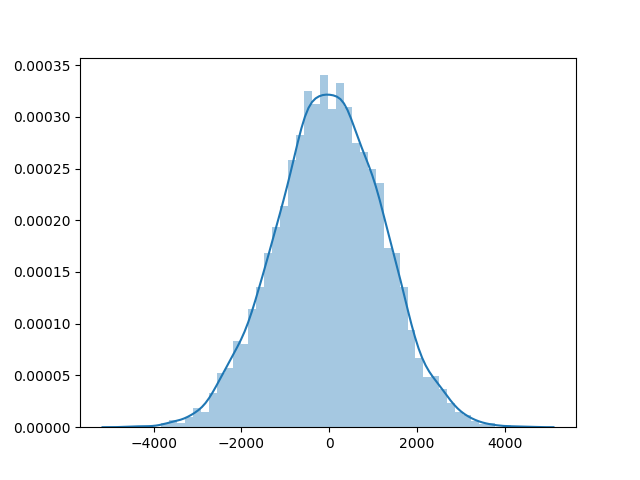

2601.049040318954
p-value = 0.0299


In [15]:
# Prueba de Hipótesis mediante permutación

def diff_of_means(data_1, data_2):
    """Diferencia entre las medias de dos arreglos (arrays)."""

    # Diferencia entre las medias de data_1, data_2
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

# Calculamos la diferencia de medias entre el salario de los hombres y el de las mujeres
empirical_diff_means = diff_of_means(feb_sal_f, feb_sal_m)

# Generamos 10,000 réplicas de permutación
perm_replicates = draw_perm_reps(feb_sal_f, feb_sal_m,
                                 diff_of_means, size = 10000)

# Calculamos el p-valor
p = np.sum(np.abs(perm_replicates) >= np.abs(empirical_diff_means)) / len(perm_replicates)

# Imprimimos los resultados en la consola
%matplotlib notebook
_ = sns.distplot(perm_replicates, hist=True)

print(empirical_diff_means)
print('p-value =', p)

- Respuesta: Si mantuviéramos como cierta la hipótesis de que los promedios de salario entre mujeres y hombres de la DGII son en realidad iguales, el valor p estimado nos dice que existe como mucho un 2.8% de casos en que el estadístico de prueba (representa -> poblacion) iguala o supera la diferencia observada entre las medias.  
<br>
- Dicho de otra manera: Si mantuviéramos como cierta la hipótesis de igualdad, la probabilidad de obtener datos muestrales que evidencien que nos equivocamos al rechazar dicha hipótesis no supera el 2.8%.   
<br>
- De manera que, para un nivel de confianza de un 97.2% podemos rechazar la hipótesis de igualdad.   
<br>
- Vamos a construir un intervalo de confianza utilizando otro método.

In [12]:
from scipy import stats
print(stats.ttest_ind(feb_sal_f, feb_sal_m))
print(stats.mannwhitneyu(feb_sal_f, feb_sal_m))

Ttest_indResult(statistic=2.1656331959644972, pvalue=0.03042616026511474)
MannwhitneyuResult(statistic=763875.0, pvalue=1.4271771686630005e-10)


In [13]:
# Prueba de hipótesis mediante bootstrap
# Calculamos la diferencia en los promedios de salarios a partir de los datos
# empirical_diff_means = diff_of_means(feb_sal_f, feb_sal_m)

# def bootstrap_replicate_1d(data, func):
#    return func(np.random.choice(data, size=len(data)))

# def draw_bs_reps(data, func, size=1):
#    """Genera réplicas de bootstrap."""

#    # Inicializa un arreglo de réplicas
#    bs_replicates = np.empty(size)

#    # Genera las réplicas
#    for i in range(size):
#        bs_replicates[i] = bootstrap_replicate_1d(data, func)

#    return bs_replicates
    
    
# Concatenamos los salarios
# sal_concat = np.concatenate((feb_sal_f, feb_sal_m))

# Inicializamos un arreglo de réplicas de bootstrap
# bs_replicates = np.empty(10000)

# for i in range(10000):
    # Generamos la muestra de bootstrap
    # bs_sample = np.random.choice(sal_concat, size=len(sal_concat))

    # Calculamos las réplicas
    # bs_replicates[i] = diff_of_means(bs_sample[:len(feb_sal_m)],
    #                               bs_sample[len(feb_sal_m):])

# Calculamos e imprimimos el p-valor
# p = np.sum(np.abs(bs_replicates) >= np.abs(empirical_diff_means)) / len(bs_replicates)
# print('p-value =', p)

intervalo de confianza 97.2% = [-2598.89987647  2686.5029053 ] Diferencia Salarial RD$


<IPython.core.display.Javascript object>


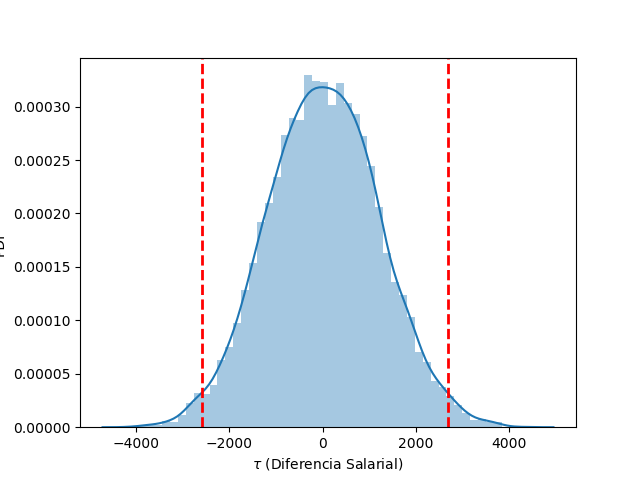

In [32]:
# Intervalo de confianza de las diferencias mediante bootstrap

# Concatenamos los salarios
sal_concat = np.concatenate((feb_sal_f, feb_sal_m))

# Inicializamos un arreglo de réplicas de bootstrap
bs_replicates = np.empty(10000)

for i in range(10000):
    # Generamos la muestra de bootstrap
    bs_sample = np.random.choice(sal_concat, size=len(sal_concat))

    # Calculamos las réplicas
    bs_replicates[i] = diff_of_means(bs_sample[:len(feb_sal_m)],
                                    bs_sample[len(feb_sal_m):])
    
# Calculamos un intervalo de confianza de un 97.2%
conf_int = np.percentile(bs_replicates, [1.4, 98.6])

# Imprimos en la consola
print('intervalo de confianza 97.2% =', conf_int, 'Diferencia Salarial RD$')

# Graficamos el histograma de las réplicas
%matplotlib notebook

#_ = plt.hist(bs_replicates, bins=100, normed=True)
_ = sns.distplot(bs_replicates, hist = True)
_ = plt.xlabel(r'$\tau$ (Diferencia Salarial)')
_ = plt.ylabel('PDF')
_ = plt.axvline(max(conf_int), linewidth = 2, color = "red", linestyle='--')
_ = plt.axvline(min(conf_int), linewidth = 2, color = "red", linestyle='--')

# Show the plot
plt.show()